In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from pyod.models.hbos import HBOS

In [94]:
dataset_path = '/home/mike/projects/jupyter/fin_data/OrderLog20220210.txt'

In [95]:
df = pd.read_csv(dataset_path)

In [96]:
df.head()

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1,GMKN,S,70000000000,1,1,23400.00,1,NaN,NaN
1,2,FIVE,B,70000000000,2,1,1760.00,10,NaN,NaN
2,3,GAZP,S,70000000000,3,1,345.48,10,NaN,NaN
3,4,MRNA-RM,B,70000000000,4,1,12000.00,1,NaN,NaN
4,5,FB-RM,B,70000000000,5,1,17000.00,1,NaN,NaN


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51849044 entries, 0 to 51849043
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   NO          int64  
 1   SECCODE     object 
 2   BUYSELL     object 
 3   TIME        int64  
 4   ORDERNO     int64  
 5   ACTION      int64  
 6   PRICE       float64
 7   VOLUME      int64  
 8   TRADENO     float64
 9   TRADEPRICE  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 3.9+ GB


In [98]:
# Number of financial instruments in the dataset
df['SECCODE'].nunique()

1155

In [99]:
# It looks like the TIME column format is HHMMSS and then millionths of a second, with 7am looking like 7 rather than 07
# Let's convert to datetime format

df['TIME_STR'] = df['TIME'].astype(str).str.zfill(12)
df['DATETIME'] = pd.to_datetime('2022-02-10 ' + df['TIME_STR'].str[:6]) + pd.to_timedelta(df['TIME_STR'].str[6:].astype(int), unit='us')

df = df.drop(columns=['TIME_STR', 'TIME'])
df.head()

,NO,SECCODE,BUYSELL,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATETIME
0,1,GMKN,S,1,1,23400.00,1,NaN,NaN,2022-02-10 07:00:00
1,2,FIVE,B,2,1,1760.00,10,NaN,NaN,2022-02-10 07:00:00
2,3,GAZP,S,3,1,345.48,10,NaN,NaN,2022-02-10 07:00:00
3,4,MRNA-RM,B,4,1,12000.00,1,NaN,NaN,2022-02-10 07:00:00
4,5,FB-RM,B,5,1,17000.00,1,NaN,NaN,2022-02-10 07:00:00


Посчитаем объем торгов сначала по всем бумагам, а затем по каждой в отдельности

In [100]:
# Let's select only transactions from the dataset with type 'S', that is, sales
sales_trades_df = df[(df['ACTION'] == 2) & (df['BUYSELL'] == 'S')]

In [101]:
# Let's calculate the total trading volume
total_volume = sales_trades_df['VOLUME'].sum()
total_volume

97718945649

In [102]:
# Trading volume (in number of shares) for each SECCODE sorted in descending order
volume_by_seccode = sales_trades_df.groupby('SECCODE')['VOLUME'].sum().sort_values(ascending=False)
volume_by_seccode

SECCODE
VTBR      89589390000
FEES       3071800000
TGKA        780400000
TGKB        659000000
IRAO        575449100
             ...     
PAZA                1
WAB-RM              1
TDC-RM              1
WEC-RM              1
CAG-RM              1
Name: VOLUME, Length: 929, dtype: int64

In [103]:
# Taking into account the fact that the entire trading volume is 97718945649, and 89589390000 is accounted for by 'VTBR' - this is a percentage:
round(volume_by_seccode.loc['VTBR'] / total_volume, 2)

0.92

Such a large volume in itself looks like an anomaly, but in order to draw any conclusions, this asset requires a separate detailed study.

In [104]:
# You can also see that there are assets whose trading volume is equal to 1, let’s see how many there are
len(volume_by_seccode[volume_by_seccode == 1])

62

In [105]:
len(volume_by_seccode[volume_by_seccode < 10])

166

/tmp/ipykernel_1516632/1697265891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_trades_df.loc[:, 'HOUR'] = sales_trades_df['DATETIME'].apply(lambda x: x.hour)


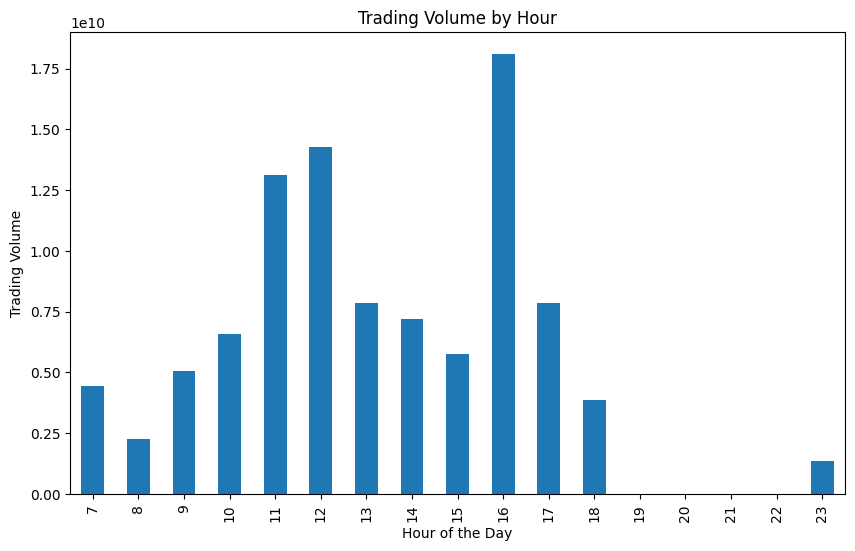

In [106]:
# Let's look at the distribution of trading volume by hour

sales_trades_df.loc[:, 'HOUR'] = sales_trades_df['DATETIME'].apply(lambda x: x.hour)
volume_by_hour = sales_trades_df.groupby('HOUR')['VOLUME'].sum()

plt.figure(figsize=(10, 6))
volume_by_hour.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Trading Volume')
plt.title('Trading Volume by Hour')
plt.show()

Judging by the schedule, there were no transactions from 19 to 23, which coincides with the trading schedule on the Moscow Exchange: https://www.moex.com/s1167

Now let's plot different time series

<Figure size 1500x700 with 0 Axes>

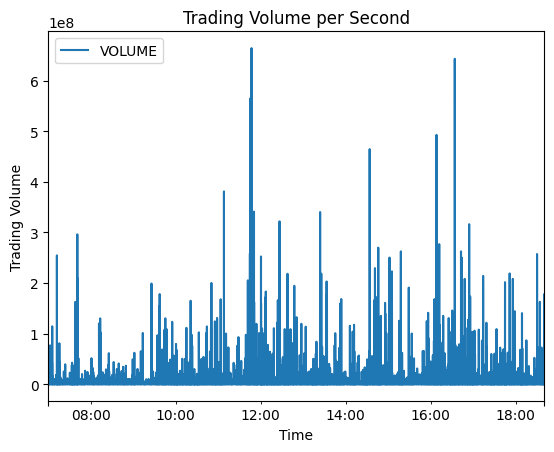

In [107]:
# Let's look at the example of 'VTBR'
_df = df[(df['SECCODE'] == 'VTBR') & (df['BUYSELL'] == 'S') & (df['ACTION'] == 2) & (df['DATETIME'].dt.hour < 19)]
_df = _df.set_index('DATETIME')

# Grouping data by seconds and summing up trading volumes
volume_by_second = _df[['VOLUME']].resample('s').sum()

plt.figure(figsize=(15, 7))
volume_by_second.plot()
plt.xlabel('Time')
plt.ylabel('Trading Volume')
plt.title('Trading Volume per Second')
plt.show()

In [108]:
# Also we can calculate the time series of the transaction price
df_vtbr = df[(df['SECCODE'] == 'VTBR') & (df['ACTION'] == 1) & (df['PRICE'] != 0) & (df['DATETIME'].dt.hour < 19)]

df_spread = pd.merge_asof(df_vtbr[df_vtbr['BUYSELL'] == 'B'], df_vtbr[df_vtbr['BUYSELL'] == 'S'], on='DATETIME', direction='nearest')

# Spread calculation
df_spread['SPREAD'] = df_spread['PRICE_y'] - df_spread['PRICE_x']
df_spread.head()

,NO_x,SECCODE_x,BUYSELL_x,ORDERNO_x,ACTION_x,PRICE_x,VOLUME_x,TRADENO_x,TRADEPRICE_x,DATETIME,NO_y,SECCODE_y,BUYSELL_y,ORDERNO_y,ACTION_y,PRICE_y,VOLUME_y,TRADENO_y,TRADEPRICE_y,SPREAD
0,20,VTBR,B,20,1,0.0396,10000,NaN,NaN,2022-02-10 07:00:00,38631,VTBR,S,38631,1,0.0438,50000000,NaN,NaN,0.0042
1,603,VTBR,B,603,1,0.0407,50000,NaN,NaN,2022-02-10 07:00:00,38631,VTBR,S,38631,1,0.0438,50000000,NaN,NaN,0.0031
2,605,VTBR,B,605,1,0.0406,50000,NaN,NaN,2022-02-10 07:00:00,38631,VTBR,S,38631,1,0.0438,50000000,NaN,NaN,0.0032
3,615,VTBR,B,615,1,0.0408,30000,NaN,NaN,2022-02-10 07:00:00,38631,VTBR,S,38631,1,0.0438,50000000,NaN,NaN,0.0030
4,651,VTBR,B,651,1,0.0411,10000,NaN,NaN,2022-02-10 07:00:00,38631,VTBR,S,38631,1,0.0438,50000000,NaN,NaN,0.0027


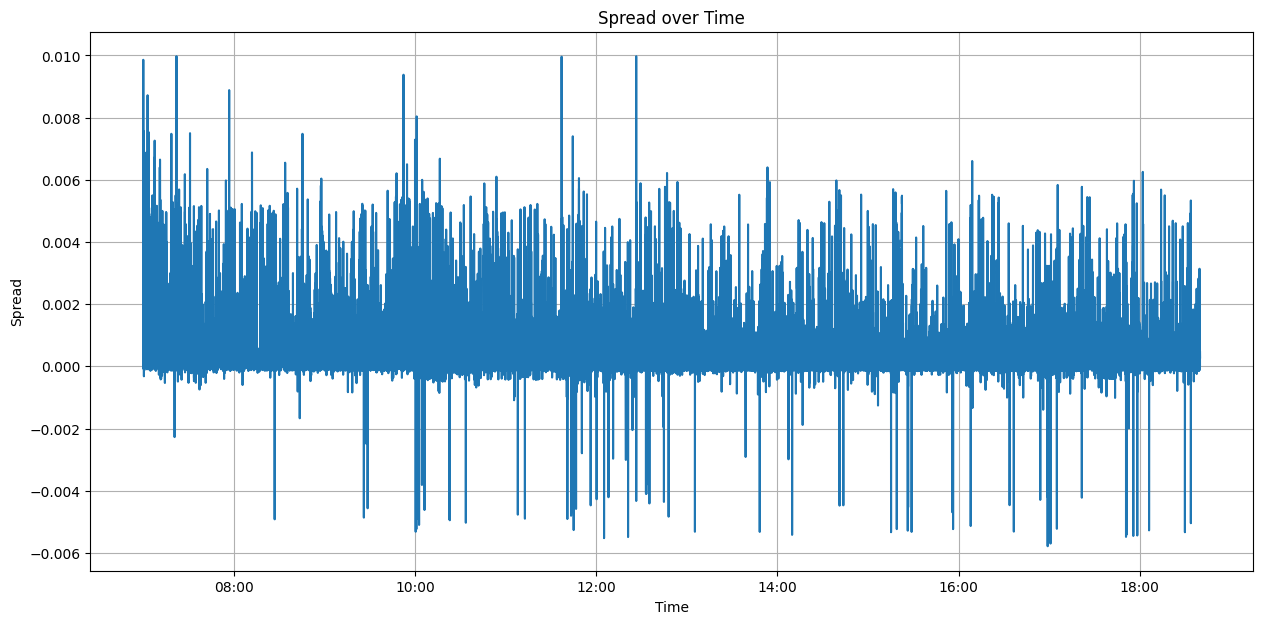

In [109]:
df_spread_sample = df_spread

# Plotting a spread time series chart
plt.figure(figsize=(15, 7))
plt.plot(df_spread_sample['DATETIME'], df_spread_sample['SPREAD'])
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Spread over Time')

date_format = DateFormatter('%H:%M')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)
plt.grid()

plt.show()

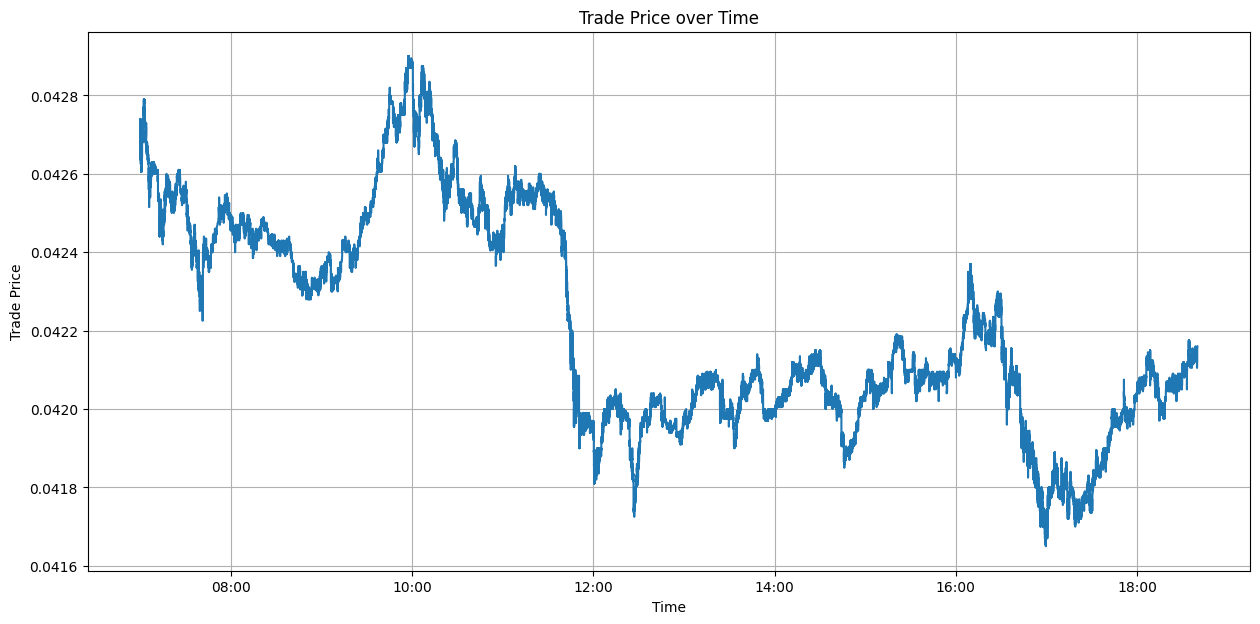

In [110]:
# Let's build a time series graph of changes in the transaction price over time for the VTBR asset

df_vtbr_price = df[(df['SECCODE'] == 'VTBR') & (df['BUYSELL'] == 'S') & (df['ACTION'] == 2) & (df['DATETIME'].dt.hour < 19)]

plt.figure(figsize=(15, 7))
plt.plot(df_vtbr_price['DATETIME'], df_vtbr_price['TRADEPRICE'])
plt.xlabel('Time')
plt.ylabel('Trade Price')
plt.title('Trade Price over Time')

date_format = DateFormatter('%H:%M')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)
plt.grid()

plt.show()

Применим Isolation Forest для поиска аномалий в объемах торгов и спреде

In [111]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(volume_by_second.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
data.head()

,0
0,1.504476
1,-0.112242
2,-0.079626
3,0.676473
4,-0.153753


In [112]:
model = IsolationForest(contamination=0.01)
model.fit(data)

IsolationForest(contamination=0.01)

In [113]:
volume_by_second['ANOMALY'] = model.predict(data)
volume_by_second.head()

,VOLUME,ANOMALY
DATETIME,,
2022-02-10 07:00:00,22400000,1
2022-02-10 07:00:01,590000,1
2022-02-10 07:00:02,1030000,1
2022-02-10 07:00:03,11230000,1
2022-02-10 07:00:04,30000,1


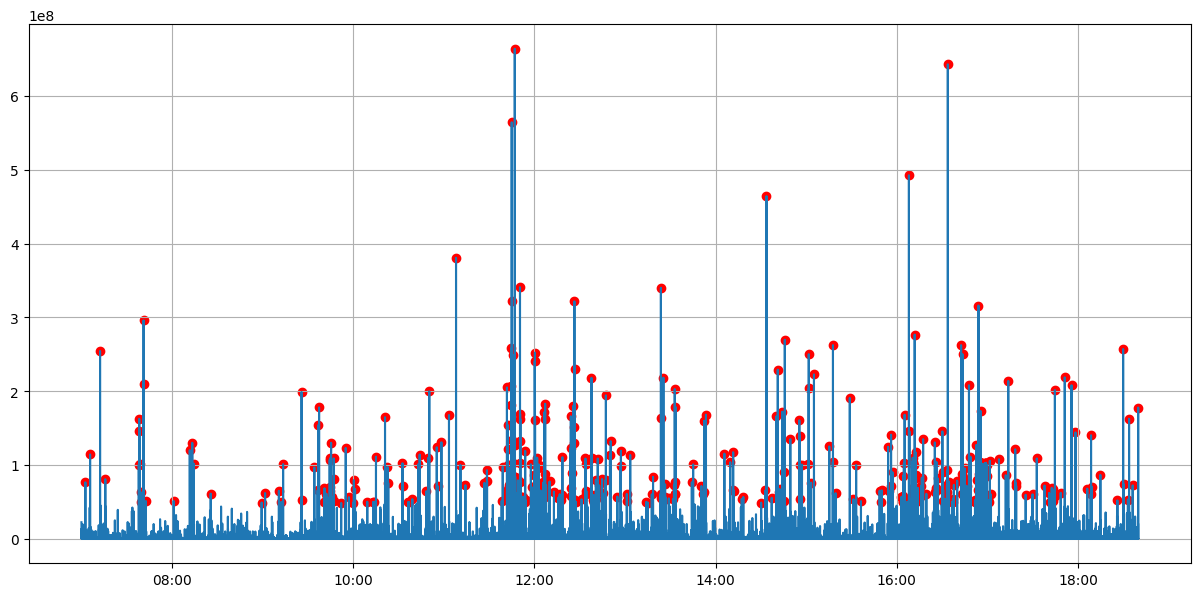

In [114]:
fig, ax = plt.subplots(figsize=(15, 7))

a = volume_by_second.loc[volume_by_second['ANOMALY'] == -1, ['VOLUME']]

ax.plot(volume_by_second.index, volume_by_second['VOLUME'])
ax.scatter(a.index, a['VOLUME'], color='red')

date_format = DateFormatter('%H:%M')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)
plt.grid()

plt.show()

In [115]:
# Now for the spread
df_spread = df_spread.set_index('DATETIME')

df_spread_by_second = df_spread[['SPREAD']].resample('s').sum()

scaler_spread = StandardScaler()
np_scaled_spread = scaler_spread.fit_transform(df_spread_by_second.values.reshape(-1, 1))
data_spread = pd.DataFrame(np_scaled_spread)
data_spread.head()

,0
0,197.575800
1,49.817823
2,1.648199
3,1.027308
4,0.141791


In [116]:
model_spread = IsolationForest(contamination=0.01)
model_spread.fit(data_spread)

IsolationForest(contamination=0.01)

In [117]:
df_spread_by_second['ANOMALY'] = model.predict(data_spread)
df_spread_by_second.head()

,SPREAD,ANOMALY
DATETIME,,
2022-02-10 07:00:00,4.324270,-1
2022-02-10 07:00:01,1.091345,-1
2022-02-10 07:00:02,0.037400,1
2022-02-10 07:00:03,0.023815,1
2022-02-10 07:00:04,0.004440,1


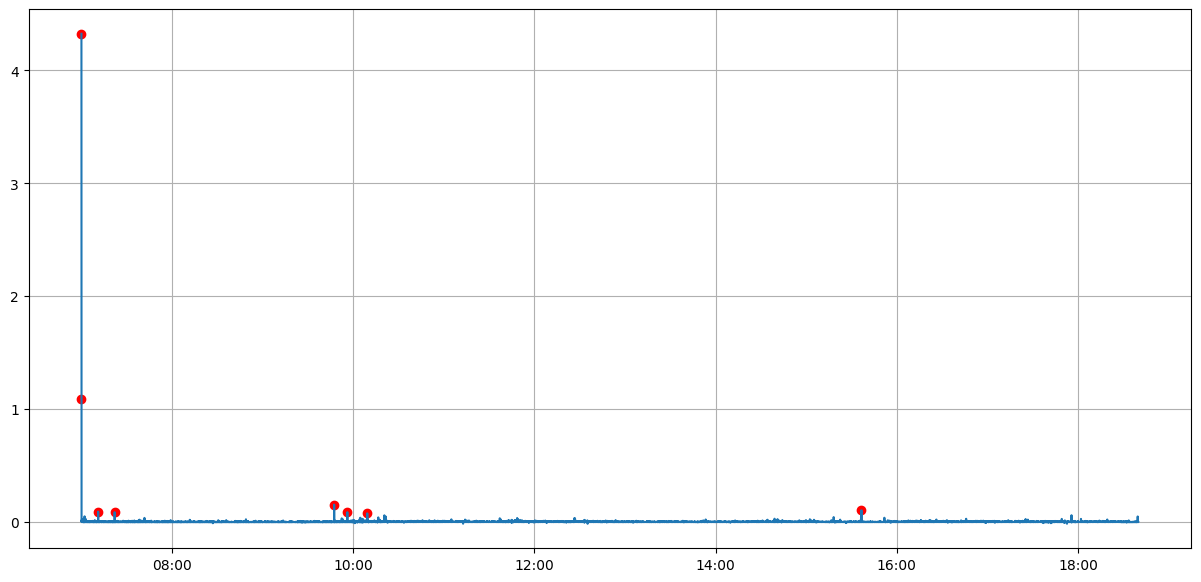

In [118]:
fig, ax = plt.subplots(figsize=(15, 7))

a_spread = df_spread_by_second.loc[df_spread_by_second['ANOMALY'] == -1, ['SPREAD']]

ax.plot(df_spread_by_second.index, df_spread_by_second['SPREAD'])
ax.scatter(a_spread.index, a_spread['SPREAD'], color='red')

date_format = DateFormatter('%H:%M')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)
plt.grid()

plt.show()

### K-means

In [119]:
# Grouping data by seconds and summing up trading volumes
volume_by_second = _df[['VOLUME']].resample('s').sum()
volume_by_second_k_means = volume_by_second.copy()

### Elbow curve

In [120]:
num_clasters = range(1, 15)
k_means = [KMeans(n_clusters=i).fit(volume_by_second_k_means) for i in num_clasters]
scores = [k_means[i].score(volume_by_second_k_means) for i in range(len(k_means))]

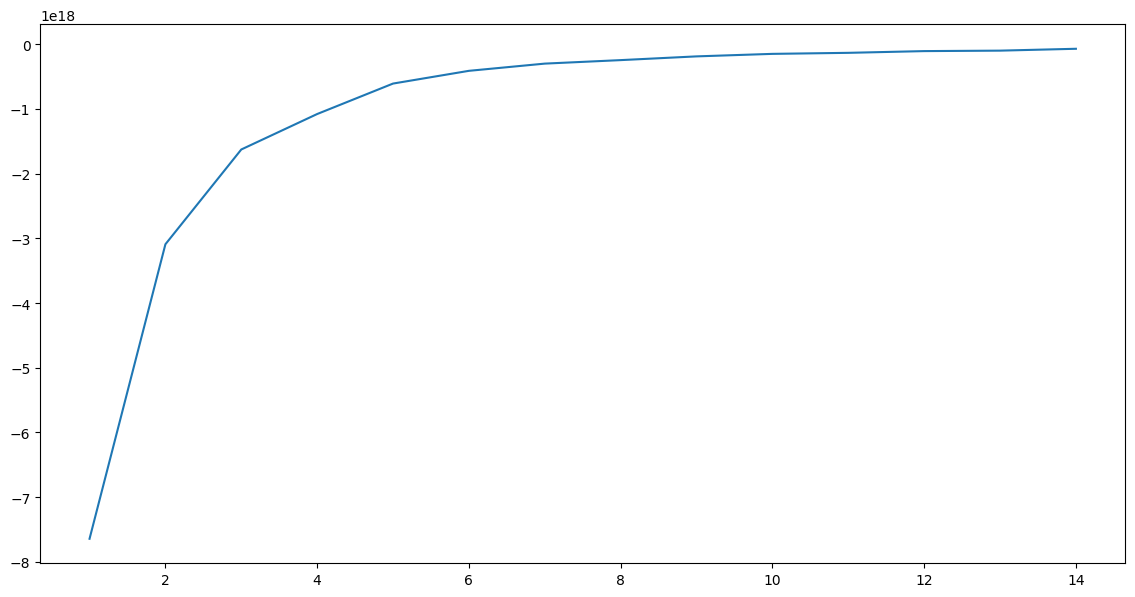

In [121]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(num_clasters, scores)
plt.show()

We can take 5 clusters

In [122]:
X = volume_by_second_k_means.values

In [123]:
X_std = StandardScaler().fit_transform(X)

In [124]:
def get_distance_by_point(data, model):
    distance = pd.Series()
    for i in range(0, len(data)):
        x_a = np.array(data.loc[i])
        x_b = model.cluster_centers_[model.labels_[i] - 1]
        distance.at[i] = np.linalg.norm(x_a - x_b)
    return distance

In [125]:
data = pd.DataFrame(X_std)

In [126]:
pca = PCA(n_components=1)
data = pca.fit_transform(data)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data.head()

,0
0,1.504476
1,-0.112242
2,-0.079626
3,0.676473
4,-0.153753


In [127]:
kmeans_model = KMeans(n_clusters=5).fit(data)

In [128]:
volume_by_second_k_means = volume_by_second_k_means.reset_index()

In [129]:
volume_by_second_k_means['CLUSTER'] = kmeans_model.predict(data)
volume_by_second_k_means.index = data.index
volume_by_second_k_means['PCA1'] = data[0]

distance = get_distance_by_point(data, kmeans_model)
n_outliers = int(0.05 * len(distance))
treshold = np.percentile(distance, 95)
volume_by_second_k_means['ANOMALY_CLS'] = (distance >= treshold).astype(int)
volume_by_second_k_means.head()

,DATETIME,VOLUME,CLUSTER,PCA1,ANOMALY_CLS
0,2022-02-10 07:00:00,22400000,4,1.504476,1
1,2022-02-10 07:00:01,590000,0,-0.112242,0
2,2022-02-10 07:00:02,1030000,0,-0.079626,0
3,2022-02-10 07:00:03,11230000,0,0.676473,0
4,2022-02-10 07:00:04,30000,0,-0.153753,0


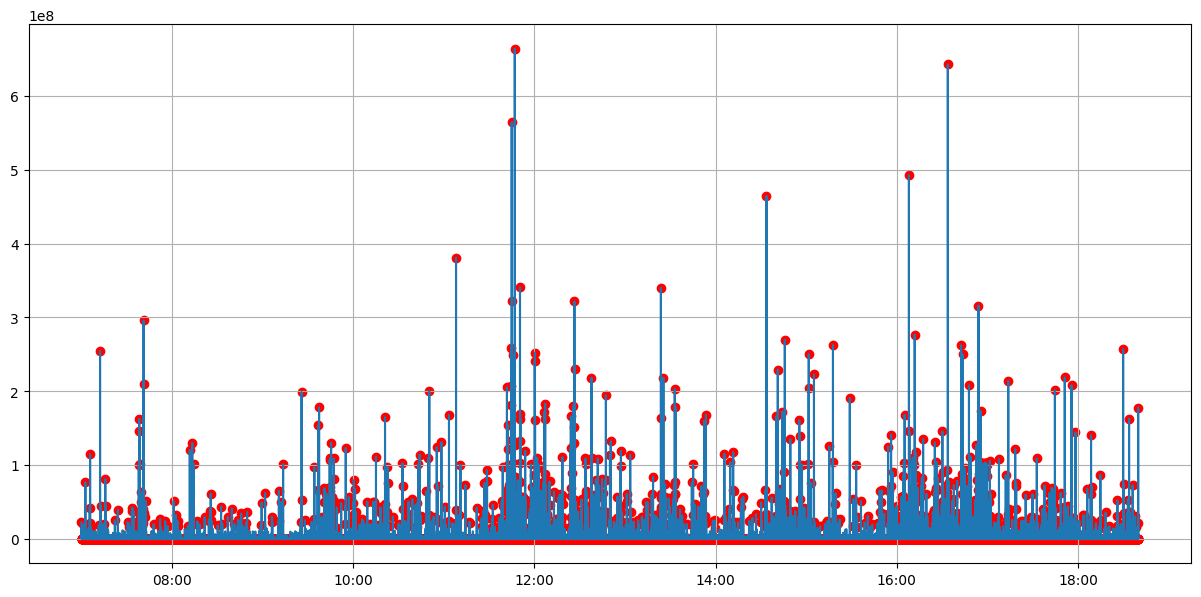

In [130]:
fig, ax = plt.subplots(figsize=(15, 7))
a = volume_by_second_k_means.loc[volume_by_second_k_means['ANOMALY_CLS'] == 1, ['VOLUME', 'DATETIME']]

ax.plot(volume_by_second_k_means['DATETIME'], volume_by_second_k_means['VOLUME'])
ax.scatter(a['DATETIME'], a['VOLUME'], color='red')

date_format = DateFormatter('%H:%M')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)
plt.grid()
plt.show()

### KNN

In [131]:
knn = NearestNeighbors(n_neighbors=3)
knn.fit(X)

NearestNeighbors(n_neighbors=3)

In [132]:
distance, indexes = knn.kneighbors(X)

In [133]:
distance

array([[    0.,     0., 20000.],
       [    0.,     0.,     0.],
       [    0.,     0.,     0.],
       ...,
       [    0.,     0.,     0.],
       [    0.,     0.,     0.],
       [    0.,     0.,     0.]])

In [134]:
volume_by_second_knn = volume_by_second_k_means.copy()

In [135]:
volume_by_second_knn['DISTANCE'] = distance.mean(axis=1)
treshold = np.percentile(volume_by_second_knn['DISTANCE'], 99)

volume_by_second_knn['ANOMALY_KNN'] = volume_by_second_knn['DISTANCE'] > treshold
volume_by_second_knn.head()

,DATETIME,VOLUME,CLUSTER,PCA1,ANOMALY_CLS,DISTANCE,ANOMALY_KNN
0,2022-02-10 07:00:00,22400000,4,1.504476,1,6666.666667,False
1,2022-02-10 07:00:01,590000,0,-0.112242,0,0.000000,False
2,2022-02-10 07:00:02,1030000,0,-0.079626,0,0.000000,False
3,2022-02-10 07:00:03,11230000,0,0.676473,0,3333.333333,False
4,2022-02-10 07:00:04,30000,0,-0.153753,0,0.000000,False


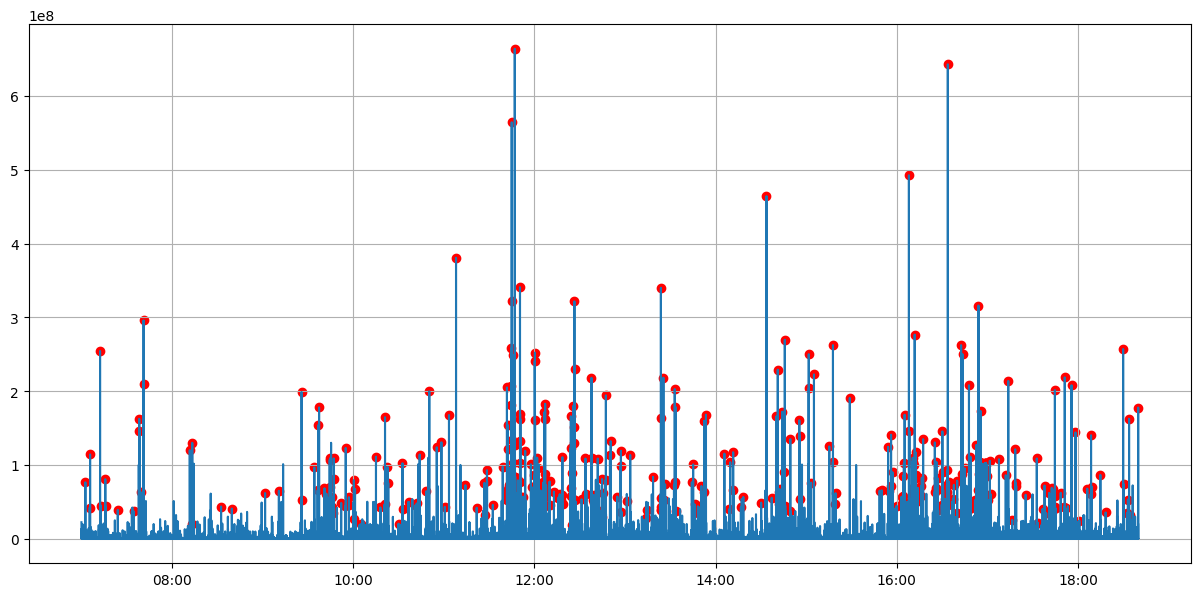

In [136]:
a = volume_by_second_knn.loc[volume_by_second_knn['ANOMALY_KNN'], ['VOLUME', 'DATETIME']]

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(volume_by_second_k_means['DATETIME'], volume_by_second_k_means['VOLUME'])
ax.scatter(a['DATETIME'], a['VOLUME'], color='red')

date_format = DateFormatter('%H:%M')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=0)
plt.grid()
plt.show()

### HBOS

In [137]:
outliers_fraction = 0.05
random_state = np.random.RandomState(42)

In [138]:
detector = HBOS(contamination=outliers_fraction)